In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import transformers
from transformers import AutoConfig, AutoTokenizer
from transformers import T5ForConditionalGeneration

In [2]:
# !pip install sentencepiece
# T5 Tokenizer is based on SentencePiece

In [3]:
MODEL_NAME = "KETI-AIR/ke-t5-large"

config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, config=config)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)

In [4]:
wiki = pd.read_json("/opt/ml/data/wikipedia_documents.json").T
wiki.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [61]:
tokenizer.SPECIAL_TOKENS_ATTRIBUTES

['bos_token',
 'eos_token',
 'unk_token',
 'sep_token',
 'pad_token',
 'cls_token',
 'mask_token',
 'additional_special_tokens']

In [73]:
tokenizer.convert_ids_to_tokens(1)

'</s>'

In [164]:
NUM_DOCUMENTS = 500
max_seq_len = 486
doc_stride = 128

QUERY_WORDS = ["대한민국", "국가", "나라"]
query = "</s>".join(QUERY_WORDS) + "</s>"

tokenized_wikis = tokenizer(
    [query + text for text in wiki['text'][0:NUM_DOCUMENTS].tolist()],
    # truncation="only_second" if pad_on_right else "only_first",
    truncation=True,
    max_length=max_seq_len,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_token_type_ids=False, 
    padding=False,
    # the max length of the model is 512...
)

tokenized_query = tokenizer(
    query,
    # truncation="only_second" if pad_on_right else "only_first",
    truncation=True,
    max_length=max_seq_len,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_token_type_ids=False, 
    padding=False,
)

In [165]:
model = model.to("cuda")

In [166]:
input_ids = torch.tensor(tokenized_wikis[0].ids).to("cuda")
out = model.encoder(input_ids.unsqueeze(0))
# must unsqueeze it!

In [167]:
out
# BaseModelOutputWithPastAndCrossAttentions

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-6.8630e-04, -2.2397e-02,  3.8018e-02,  ...,  2.5040e-02,
          -1.9651e-02,  1.7822e-01],
         [ 2.4209e-03,  3.0009e-05, -1.0977e-02,  ..., -7.0875e-03,
          -1.2998e-03, -3.5379e-04],
         [ 6.9664e-03, -1.5309e-01, -1.1257e-02,  ...,  3.9806e-02,
          -8.6058e-02,  1.0383e-01],
         ...,
         [-1.8533e-03, -6.3346e-03,  1.3526e-01,  ..., -1.6619e-01,
           3.0390e-03, -3.1052e-02],
         [-7.1957e-03, -4.7361e-02, -2.0515e-02,  ..., -1.1426e-01,
          -4.2452e-02,  6.4274e-02],
         [ 2.1050e-03, -3.4081e-03, -7.4637e-03,  ..., -9.6435e-03,
          -2.2990e-03, -4.4419e-04]]], device='cuda:0', grad_fn=<MulBackward0>), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [168]:
last_hidden_state = out['last_hidden_state']
last_hidden_state.shape
# batch_size, seq_length, embedding_dim

torch.Size([1, 175, 1024])

In [169]:
sum_hidden_state = torch.sum(last_hidden_state, dim=1)
sum_hidden_state.shape

torch.Size([1, 1024])

In [170]:
document_embeddings = []
for i in range(NUM_DOCUMENTS):
    with torch.no_grad():
        input_ids = torch.tensor(tokenized_wikis[i].ids).to("cuda")
        out = model.encoder(input_ids.unsqueeze(0))
        # collate_fn not implemented yet

        last_hidden_state = out['last_hidden_state']
        # batch_size, seq_length, embedding_dim

        document_embedding = torch.mean(last_hidden_state, dim=1)
        # batch_size, embedding_dim

        document_embeddings.append(document_embedding)

document_embeddings = torch.cat(document_embeddings, dim=0)
document_embeddings.shape

torch.Size([500, 1024])

In [171]:
document_embeddings = document_embeddings.detach().cpu().numpy()

In [172]:
document_embeddings.shape

(500, 1024)

In [173]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

N_CLUSTERS = 16

pca = PCA(n_components=64)
km  = KMeans(n_clusters=N_CLUSTERS)

In [174]:
pca_result = pca.fit_transform(document_embeddings)
pca_result.shape

(500, 64)

In [175]:
pred = km.fit_predict(pca_result)

In [177]:
pred

array([ 6,  6,  6,  6,  0,  5,  5,  5,  5,  5,  4,  0,  4,  4, 10,  1, 12,
        9,  9,  9, 12, 10,  9,  9, 12,  9, 10,  9,  9,  9,  9,  1, 12,  9,
       10,  9,  9, 12, 12,  7,  1,  9, 12, 10, 10, 12,  5, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11,  1,  0,  0,  5,  5,  5,  4, 10,  4,  4,
        4,  4,  3,  3,  3,  4,  4, 15, 12, 10, 10, 10, 10,  9,  8,  8, 10,
       10,  9,  9,  4, 10,  4,  1, 14, 14, 14, 11, 11, 14, 14, 14, 10, 12,
       10, 10,  3, 10,  1,  4, 15,  9,  1,  4,  1, 10, 12, 12, 12, 10, 12,
        4, 11,  6,  5,  2,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  6,  6, 11,  4,  0,  0,  0,  5,
        5,  5,  0,  5,  0,  0,  5,  5,  9,  3,  3,  9,  9,  9,  9,  9, 10,
        4,  4,  4,  9,  4,  1,  1,  1,  4,  9,  9, 12,  5,  5,  4, 12,  9,
        9,  9, 12,  6, 12,  6, 12, 10, 10, 10, 10, 12, 12, 13,  5,  5, 13,
       10,  6, 10,  7, 10,  7,  7,  7,  7,  7,  7,  7, 10, 10,  4,  4,  1,
        8,  8,  1,  1,  8

In [176]:
pca.explained_variance_ratio_

array([0.11717352, 0.09924419, 0.05870019, 0.04710253, 0.03983814,
       0.03281511, 0.023884  , 0.02298333, 0.02246742, 0.02102582,
       0.01853177, 0.01656264, 0.01556093, 0.014333  , 0.0140779 ,
       0.01252446, 0.01181389, 0.01063189, 0.00994587, 0.00976719,
       0.00929618, 0.00871282, 0.00830405, 0.00813317, 0.00730316,
       0.00720605, 0.0066682 , 0.00608813, 0.0059413 , 0.00585665,
       0.00573045, 0.00544107, 0.0050923 , 0.00493745, 0.00473285,
       0.00467444, 0.00462669, 0.00452342, 0.00448339, 0.00421065,
       0.00403128, 0.00390018, 0.00377317, 0.00368363, 0.00363351,
       0.00346378, 0.00334782, 0.00327828, 0.00323699, 0.00316312,
       0.00306653, 0.00303262, 0.00297722, 0.00289491, 0.00283684,
       0.00278331, 0.00269235, 0.00262293, 0.00252432, 0.00248157,
       0.00245351, 0.00242693, 0.00238774, 0.00233888], dtype=float32)

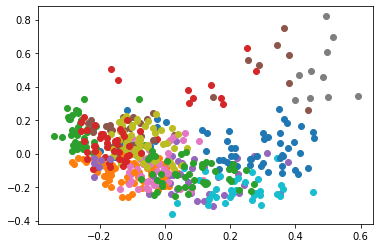

In [179]:
for c in range(N_CLUSTERS):
    i = np.where(pred == c)
    plt.scatter(pca_result[i,0], pca_result[i,1], label = i)

In [180]:
wiki[0:NUM_DOCUMENTS][pred == 0]

,text,corpus_source,url,domain,title,author,html,document_id
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
11,"아미노산(amino acid)은 생물의 몸을 구성하는 단백질의 기본 구성 단위로, ...",위키피디아,TODO,None,아미노산,None,None,11
59,"한편, 흔히 01410으로 알려진 한국통신하이텔은 전화망을 활용한 부가통신 서비스의...",위키피디아,TODO,None,PC통신,None,None,59
60,KETEL의 초기화면\n\n\n CONNECT 240\n [[[[[[[\n ### ...,위키피디아,TODO,None,PC통신,None,None,60
149,잉글랜드어는 라틴어와 프랑스어의 어휘에서 많은 영향을 받았으며 지리적 고립으로 인한...,위키피디아,TODO,None,영어,None,None,149
150,잉글랜드어와 다른 연관 언어 사이에는 전혀 다른 의미를 지니는 단어가 유사한 음운을...,위키피디아,TODO,None,영어,None,None,150
151,잉글랜드어의 파열음이 유성음이나 유기음으로 발음되는데에는 뚜렷한 일반적인 규칙이 없...,위키피디아,TODO,None,영어,None,None,151
155,"19세기(19世紀, 19th century)는 1801년부터 1900년까지의 기간이...",위키피디아,TODO,None,19세기,None,None,155
157,엔트로피 인코딩 혹은 엔트로피 부호화(entropy encoding)는 심볼이 나올...,위키피디아,TODO,None,엔트로피 부호화,None,None,157
158,패션 산업은 현대의 산물이다. 19세기 중반 이전에 대부분의 옷은 주문 제작 되었다...,위키피디아,TODO,None,패션,None,None,158


In [181]:
kmeans_result_sum = []
for c in range(N_CLUSTERS):
    kmeans_result_sum.append(0)
    for w in QUERY_WORDS:
        kmeans_result_sum[c] += np.sum(wiki['text'][0:NUM_DOCUMENTS][pred == c].str.count(w))

print(kmeans_result_sum)

[11, 28, 14, 18, 14, 16, 72, 39, 42, 35, 30, 11, 37, 37, 0, 15]


In [182]:
kmeans_result_count = []
for c in range(N_CLUSTERS):
    kmeans_result_count.append(0)
    for w in QUERY_WORDS:å
        kmeans_result_count[c] += np.sum(wiki['text'][0:NUM_DOCUMENTS][pred == c].str.contains(w))

print(kmeans_result_count)

[5, 13, 8, 4, 8, 6, 16, 10, 22, 17, 15, 7, 16, 17, 0, 5]


In [183]:
wiki[0:NUM_DOCUMENTS][pred == np.argmax(kmeans_result_sum)]

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
121,언어(言語)에 대한 정의는 여러가지 시도가 있었다. 아래는 그러한 예의 일부이다.\...,위키피디아,TODO,None,언어,None,None,121
124,"마약(痲藥, drug)은 향정신성 의약품의 출물로서 환각과 중독을 일으키는 알칼로이...",위키피디아,TODO,None,마약,None,None,124
145,"철학이란, 대상을 다시 한번 더 문제삼아 되돌아 보는 '반성적 사고'를 이른다.\n...",위키피디아,TODO,None,기술,None,None,145
146,"잉글랜드어(English language), 또는 흔히 영어(英語)는 영국의 잉글랜...",위키피디아,TODO,None,영어,None,None,146
190,"쿠바의 국교는 전통적으로 로마 가톨릭교회이지만, 개신교도 소수 존재한다. 정부에서 ...",위키피디아,TODO,None,쿠바,None,None,190
192,"쿠바는 라틴 아메리카의 영화 대국인 브라질, 아르헨티나, 멕시코에 비해 제작 편수는...",위키피디아,TODO,None,쿠바,None,None,192


In [184]:
wiki[0:NUM_DOCUMENTS][pred == np.argmax(kmeans_result_count)]

,text,corpus_source,url,domain,title,author,html,document_id
82,"1월(一月, January)은 율리우스력과 그레고리력에서 한 해의 첫 번째 달이며,...",위키피디아,TODO,None,1월,None,None,82
83,"영어 'January'(라틴어 Mensis Ianuarius, ""month of J...",위키피디아,TODO,None,1월,None,None,83
221,제7회 전국동시지방선거에서 영남권 광역단체장 5곳과 경기·인천지역을 사수하고 서울을...,위키피디아,TODO,None,자유한국당,None,None,221
222,통합민주당 (1995년)\n* 1995년 12월 6일: 전두환 노태우의 사법처리로 ...,위키피디아,TODO,None,자유한국당,None,None,222
225,새누리당의 공약이 포퓰리즘이 아니냐는 비판이 있다. 당은 무상급식을 야당의 포퓰리...,위키피디아,TODO,None,자유한국당,None,None,225
...,...,...,...,...,...,...,...,...
358,"1959년 국제계량단위국(BIPM)에 가입하고 난 후, 1961년 국제단위계를 법정...",위키피디아,TODO,None,척관법,None,None,358
359,제자백가\n춘추전국시대에 이르러 중국 사회는 큰 변혁을 일으켰다. 주나라 왕실이 쇠...,위키피디아,TODO,None,춘추 전국 시대,None,None,359
490,"노원구에 속하는 모든 법정동인 월계동, 공릉동, 하계동, 중계동, 상계동은 각각 조...",위키피디아,TODO,None,노원구,None,None,490
491,"과거에는 광운대역(성북역)에서 경춘선 무궁화호, 통일호, 비둘기호를 탈 수 있었으나...",위키피디아,TODO,None,노원구,None,None,491


In [198]:
input_ids = torch.tensor(tokenized_query[0].ids).to("cuda")
query_out = model.encoder(input_ids.unsqueeze(0))
# must unsqueeze it!
last_hidden_state = query_out['last_hidden_state']
# batch_size, seq_length, embedding_dim

query_embedding = torch.mean(last_hidden_state, dim=1)
# batch_size, embedding_dim
query_embedding = query_embedding.detach().cpu().numpy()


In [199]:
query_embedding

array([[-0.004831  , -0.04861904, -0.0074807 , ...,  0.01998578,
        -0.00511851,  0.03638985]], dtype=float32)

In [200]:
query_embedding = pca.transform(query_embedding)

In [201]:
query_embedding

array([[ 2.95922533e-03, -4.82631981e-01, -1.61688522e-01,
         3.47621381e-01, -3.89918610e-02,  5.20646751e-01,
         3.59098703e-01,  2.39874572e-01, -2.67860480e-02,
         2.47688629e-02, -2.31707484e-01,  1.03656948e-01,
        -3.32598090e-01, -1.30423650e-01,  1.17354915e-01,
         6.46396130e-02,  8.39671344e-02, -1.56549260e-01,
         1.52077526e-03,  8.37613791e-02, -7.67711401e-02,
         1.06364414e-01, -4.13223505e-02, -1.50903910e-01,
         4.26493548e-02,  3.87434438e-02, -3.77482921e-02,
         1.28150538e-01,  8.80514979e-02,  1.42083347e-01,
         2.97188573e-02,  2.38943156e-02,  1.97227076e-02,
         5.00295796e-02, -1.45477802e-02,  5.30634373e-02,
        -9.17192772e-02,  4.54789400e-02, -4.39818762e-02,
        -5.58776073e-02,  4.49891686e-02, -6.98001087e-02,
        -1.45183593e-01,  1.13250017e-01, -2.45440975e-02,
         1.30692422e-02,  4.52497005e-02, -4.99296859e-02,
         9.41872522e-02, -2.30361149e-02, -2.09177956e-0

In [202]:
from sklearn.neighbors import KDTree

kdt = KDTree(result, leaf_size=10)

In [208]:
dist, idx = kdt.query(query_embedding, k=10)

In [209]:
dist

array([[1.04873522, 1.05683279, 1.06438777, 1.06761433, 1.08065351,
        1.09480093, 1.10286103, 1.10386885, 1.11421152, 1.12334715]])

In [210]:
wiki['title'][0:NUM_DOCUMENTS].iloc[idx.flatten()]

10      주기율표
11      아미노산
32       벡터곱
37      가타카나
45       정주영
15    푸리에 급수
58      PC통신
42       정주영
38       정주영
13      히라가나
Name: title, dtype: object

In [206]:
wiki['text'][0]

'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

In [207]:
wiki['text'][58]

"사설 BBS는 개인 또는 단체가 운영하는 주로 비영리 목적의 소규모 PC통신 서비스였다. 자발적으로 발생한 이러한 사설 BBS들은 상용 PC통신 서비스가 대중화되기 전까지 PC통신의 개척자 역할을 하였다.\n\n대한민국 사설 BBS는 1988년 3월 이주희가 개설한 'The FIRST'과 1988년 5월 바이트전자가 개설하고 최승철이 운영한 '바이트 네트(Byte-Net)'가 효시로 알려져 있다. 곧이어 대구에서XENIX 환경에서 4개의 접속노드를 갖추어 다중접속자를 지원하는 '달구벌'이 개설되고, 이듬해에는 '엠팔(EMPal) BBS'가 개설되는데, 이 두개의 BBS는 당시 한국데이터통신에서 제공한 전자사서함 'H-mail'의 사용자들을 주축으로 만들어졌다. 또 와일드캣과 8개의 전화 회선을 이용하여 운영하는 '네트워크 서울'도 있었다.\n\n이렇게 출발한 사설 BBS들은 외국산 호스트 프로그램—주로 와일드캣—을 한글화 해서 사용했는데, 1990년 10월에 최초의 국산 호스트 프로그램인 '카페'가 조병철에 의해서 공개되었고, 이를 바탕으로 하성욱의 '곰주인', 김성철의 '밀키웨이'가 나왔고, 이와 별도로 1991년 최오길의 '호롱불'이 등장하여 전국적인 사설 BBS 네트워크가 구축되었다.\n\n당시 유명 사설 BBS는 다음과 같다.\n* 달구벌\n* 엠팔(EMPal BBS)\n* 메디네트\n* 참세상\n* 평화만들기\n*까치멀"

In [163]:
wiki['text'][56]

'PC통신(피시통신, 피씨통신)은 개인용 컴퓨터(PC)를 다른 컴퓨터와 통신 회선으로 연결하여 자료를 주고 받는 것을 말한다. 전화망을 사용하여 문자, 숫자, 영상, 음성 데이터 등을 전송한다. 개인용 컴퓨터끼리 서로 연결한 통신 형태도 포함되지만, 보통은 정보 서비스 제공을 위한 호스트 컴퓨터와 통신 장비를 설치하고 여기에 가입한 사람들이 개인용 컴퓨터로 접속하여 이용하는 형태의 전화 회선을 통한 통신 네트워크 서비스를 가리킨다. 이때 통신 회선은 주로 전화 모뎀을 통한 전화 회선(PSTN)이 사용되지만 ISDN 등의 다른 회선이 사용되는 경우도 있다.\n\n개인용 컴퓨터가 보편화되면서 1990년대에 게시판과 대화방, 그리고 자료실을 제공하는 PC통신 서비스 회사가 설립되었다.'